In [1]:
import veux
import numpy as np

import xara.units.fks as units
from xara.units.fks import kip, ksi

from xsection.library import from_aisc
from xsection.analysis import SectionInteraction

import matplotlib.pyplot as plt
plt.style.use("veux-web")



## Steel

In [2]:

shape = from_aisc("W14x426", units=units)
veux.render(shape.model)

/Users/claudio/packages/veux/src/veux/frame/__init__.py:203: UserWarning: 'PlaneModel' object has no attribute 'cell_prototypes'
  warnings.warn(str(e))


   FAILURE :: Iter:    20, Norm:     1.55354, Norm deltaX: 8.07691e-06
   FAILURE :: Iter:    20, Norm:     4.95488, Norm deltaX: 7.17333e-06


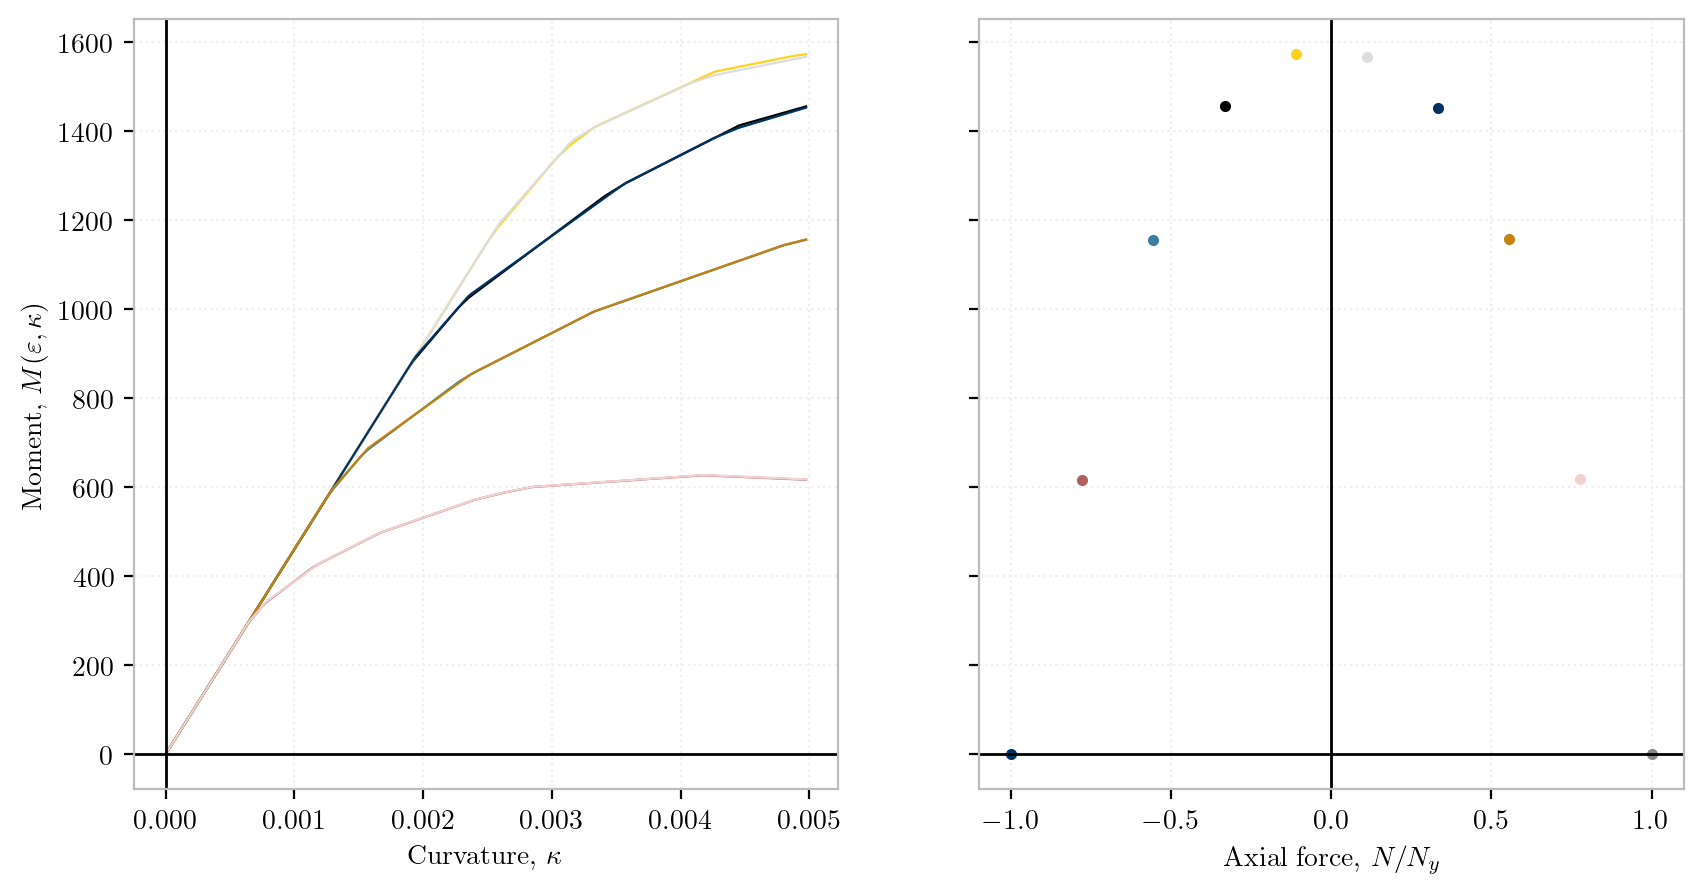

In [3]:
steel = {
        "type": "J2",
        "nu": 0.3,
        "E":  29000*ksi,
        "Fy":    50*ksi,
        "Hiso": 0.003*29e3*ksi,
        "Fs": 0, "Fo": 0, "Hsat": 16
}

Ny = shape.area*steel["Fy"]

axial = np.linspace(-Ny, Ny, 10)

si = SectionInteraction(("ShearFiber", shape, steel), axial=axial)

fig, ax = plt.subplots(1,2, figsize=(10, 5), sharey=True)

for N, M, k in si.moment_curvature():
    ax[0].plot(k, M, '-') #, label=f"{N/kip:.0f} kip")
    ax[1].plot([N/Ny], [M[-1]], '.')


ax[0].axvline(0, color="k", lw=1)
ax[0].axhline(0, color="k", lw=1)
ax[1].axvline(0, color="k", lw=1)
ax[1].axhline(0, color="k", lw=1)
ax[0].set_xlabel("Curvature, $\\kappa$")
ax[0].set_ylabel("Moment, $M(\\varepsilon, \\kappa)$")
ax[1].set_xlabel("Axial force, $N/N_y$");

## Concrete

In [4]:
from xsection.library import Rectangle, Circle
from xsection import CompositeSection

h = 24
b = 15
d = 7/8
r = 0 #d/2

c = 1.5

bar = Circle(d/2, z=2, mesh_scale=1/2, divisions=4, name="rebar")

shape = CompositeSection([
            Rectangle(    b, h,     z=0, name="cover"),
            Rectangle(b-2*c, h-2*c, z=1, name="core"),
            *bar.linspace([-b/2+c+r, -h/2+c+r], [ b/2-c-r,-h/2+c+r], 3), # Top bars
            *bar.linspace([-b/2+c+r,        0], [ b/2-c-r,       0], 2), # Center bars
            *bar.linspace([-b/2+c+r,  h/2-c-r], [ b/2-c-r, h/2-c-r], 3)  # Bottom bars
        ])


print(shape.summary())

artist = veux.create_artist(shape.model) #veux.model.FiberModel(shape.create_fibers()))
# artist.draw_samples()
artist.draw_outlines()
artist.draw_surfaces()
artist


  [nn]    Area                    360.0
  [nm]    Centroid                  0.0         0.0,        0.0
  [nw|v]                            0.0   2.636e-15,  7.888e-15

  [mm]    Flexural moments    2.403e+04   1.728e+04,   6.75e+03,  1.599e-13
  [mv|w]                     -7.344e+03       0.176,      1.329

          Shear center              0.0   1.019e-05,  0.0001968

  [ww]    Warping constant     6.61e+04  (  6.61e+04 at S.C.)
          Torsion constant    1.669e+04
  [vv]    Bishear             7.344e+03
        


   FAILURE :: Iter:    20, Norm:     165.789, Norm deltaX: 0.000585341
   FAILURE :: Iter:    20, Norm:     63.2987, Norm deltaX: 0.000110827
   FAILURE :: Iter:    20, Norm:     17.9758, Norm deltaX: 0.000136052
   FAILURE :: Iter:    20, Norm:     10.3745, Norm deltaX: 0.000445332
   FAILURE :: Iter:    20, Norm:    0.751799, Norm deltaX: 7.09398e-05


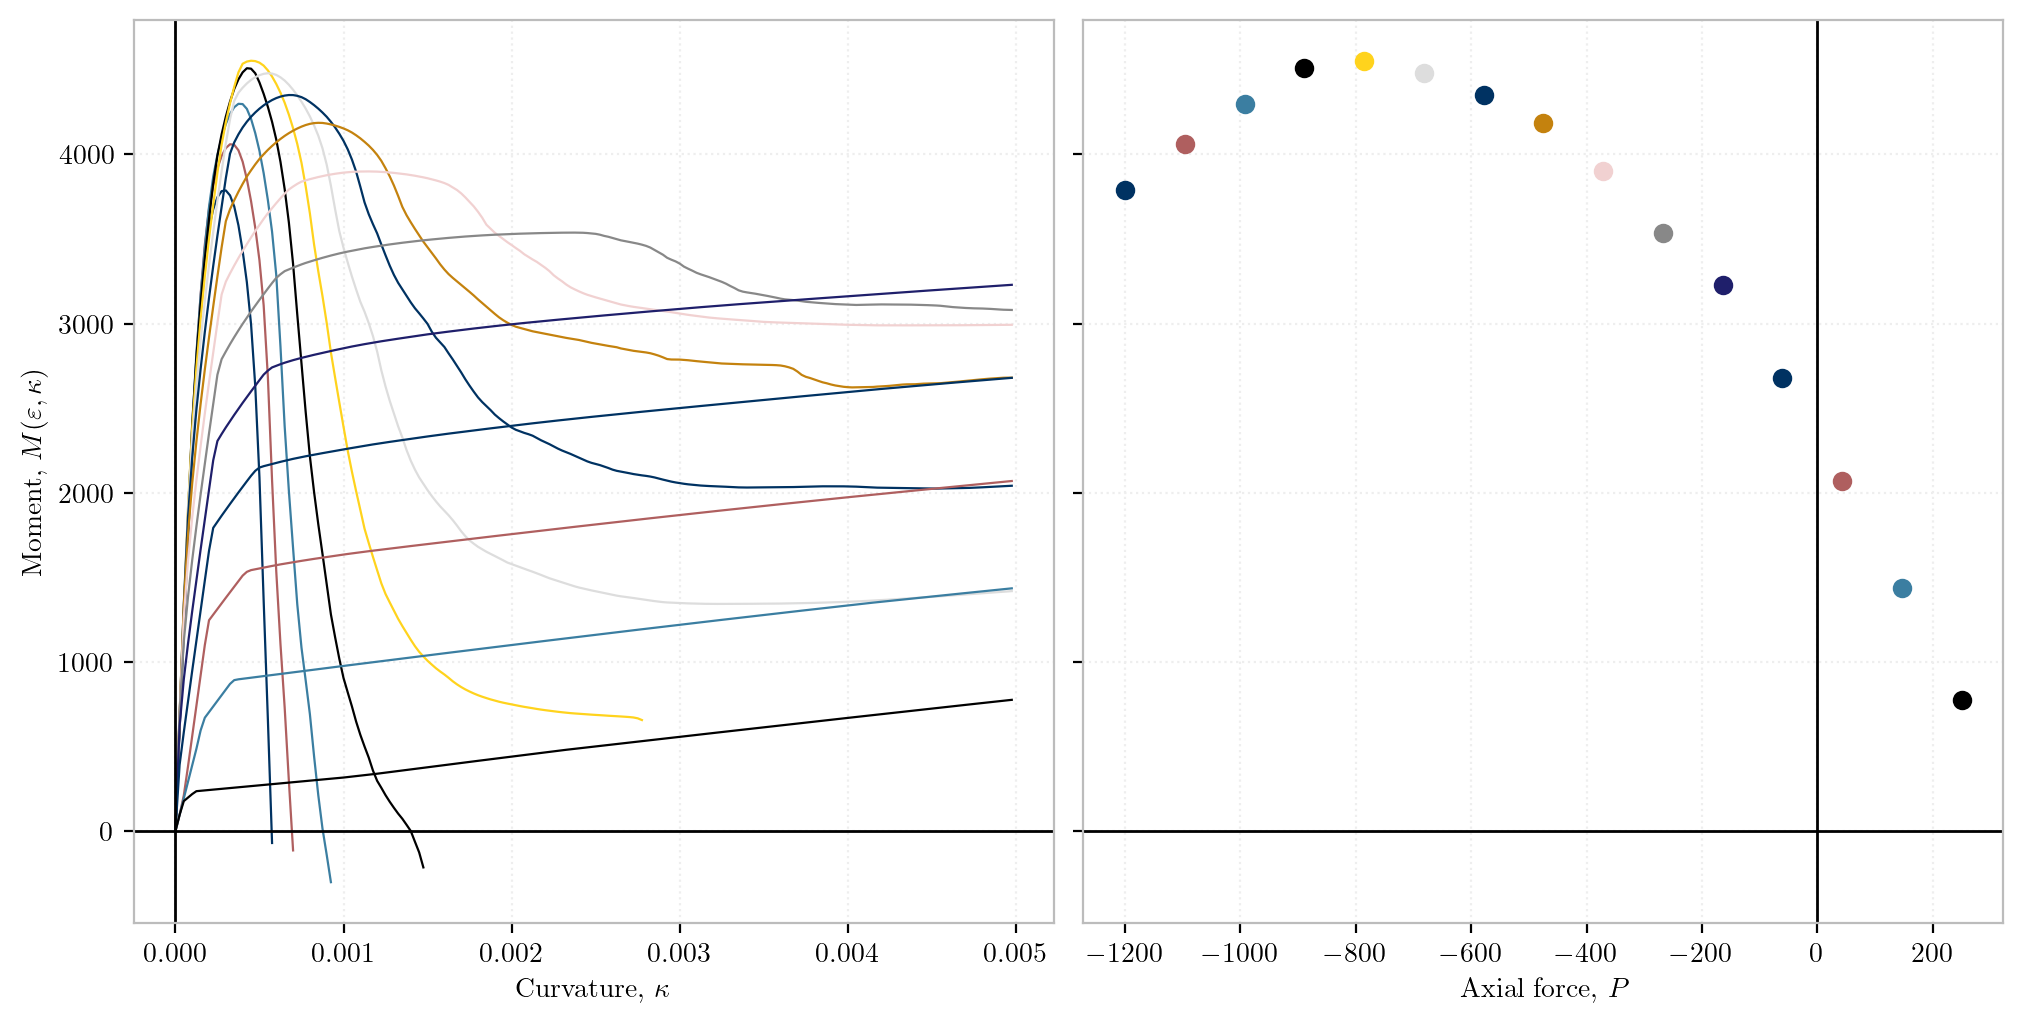

In [5]:
from xara.units.iks import kip, ksi

mat = [
    { # Confined
        "name": "core",
        "type": "Concrete01",
        "Fc":   6*ksi,
        "ec0":  0.004,
        "Fcu":  5*ksi,
        "ecu":  0.014,
    },
    { # Unconfined
        "name": "cover",
        "type": "Concrete01",
        "Fc":  -5*ksi,
        "ec0": -0.002,
        "Fcu":  0,
        "ecu": -0.006,
    },
    {
        "name": "rebar",
        "type": "Steel01",
        "E":   30e3*ksi,
        "Fy":    60*ksi,
        "b":   0.01
    }
]

axial = np.linspace(-1200*kip, 250*kip, 15)

si = SectionInteraction(("Fiber", shape, mat), axial=axial)

fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True, figsize=(10, 5))
mmax = []

for n, m, k in si.moment_curvature():
    ax[0].plot(k, m, '-')

    # ax[1].plot([n]*len(m), m, '-', lw=0.3, markersize=0.5)
    ax[1].plot([n], [max(m)], 'o')

ax[0].axvline(0, color="k", lw=1)
ax[0].axhline(0, color="k", lw=1)
ax[1].axvline(0, color="k", lw=1)
ax[1].axhline(0, color="k", lw=1)
ax[0].set_xlabel("Curvature, $\\kappa$")
ax[0].set_ylabel("Moment, $M(\\varepsilon, \\kappa)$")
ax[1].set_xlabel("Axial force, $P$");